In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# For model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# For Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [12]:
def load_and_explore_data(file_path):
    """
    Load and perform initial data exploration
    """
    # Load data
    df = pd.read_csv(file_path)
    
    print("1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Shape of dataset: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())

    df.drop(columns=['Series_Title'], inplace=True)
    df.drop(columns=['Overview'], inplace=True)
    df.drop(columns=['Director'], inplace=True)
    df.drop(columns=['Star'], inplace=True)
    df.drop(columns=['Certificate'], inplace=True)

    df['Gross'] = df['Gross'].str.replace(',', '')
    df['Gross'] = df['Gross'].astype('float64')

    df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)
    
    return df

In [13]:
def perform_eda(df):
    print("\n2. Detailed EDA")
    print("-" * 50)
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    print("\nNumerical Columns:", numerical_cols.tolist())
    print("Categorical Columns:", categorical_cols.tolist())
    
    # Univariate Analysis
    print("\n2.1 Univariate Analysis")
    print("-" * 30)
    
    # For numerical columns
    print("\nNumerical Columns Summary:")
    print(df[numerical_cols].describe())
    
    # Visualize distributions
    for col in numerical_cols:
        plt.figure(figsize=(10, 4))
        
        # Histogram
        plt.subplot(121)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        
        # Box plot
        plt.subplot(122)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
        plt.tight_layout()
        plt.show()
    
    # For categorical columns
    print("\nCategorical Columns Summary:")
    for col in categorical_cols:
        print(f"\n{col} value counts:")
        print(df[col].value_counts())
        print(f"{col} unique values:", df[col].nunique())
        
        # Bar plot
        plt.figure(figsize=(10, 4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.show()
    
    # Bivariate Analysis
    print("\n2.2 Bivariate Analysis")
    print("-" * 30)
    
    # Correlation matrix for numerical columns
    if len(numerical_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()
    
    # Chi-square test for categorical columns
    if len(categorical_cols) > 1:
        print("\nChi-square test results for categorical variables:")
        for col1 in categorical_cols:
            for col2 in categorical_cols:
                if col1 < col2:
                    contingency_table = pd.crosstab(df[col1], df[col2])
                    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
                    print(f"{col1} vs {col2}:")
                    print(f"Chi-square statistic: {chi2:.2f}")
                    print(f"p-value: {p_value:.4f}\n")
    
    return numerical_cols, categorical_cols

In [25]:
def preprocess_data(df, numerical_cols, categorical_cols):
    print("\n3. Data Preprocessing")
    print("-" * 50)

    target_column='Gross'
    
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle missing values
    print("\n3.1 Handling Missing Values")
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if col in numerical_cols:
                # Fill numerical missing values with median
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
            else:
                # Fill categorical missing values with mode
                df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    # Remove duplicates
    df_processed.drop_duplicates(inplace=True)
    
    # Encode categorical variables
    print("\n3.2 Encoding Categorical Variables")
    label_encoders = {}
    for col in categorical_cols:
        if col != target_column:  # Don't encode target column yet
            label_encoders[col] = LabelEncoder()
            df_processed[col] = label_encoders[col].fit_transform(df_processed[col])
    
    # Prepare features and target
    X = df_processed.drop(target_column, axis=1)
    y = df_processed[target_column]

    scaler = StandardScaler()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    numerical_cols_present = [col for col in numerical_cols if col in X.columns]
    if numerical_cols_present:
        X_train[numerical_cols_present] = scaler.fit_transform(X_train[numerical_cols_present])
        X_test[numerical_cols_present] = scaler.transform(X_test[numerical_cols_present])
    
    print("\n3.3 Data Split Information:")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler, label_encoders

In [26]:
df = load_and_explore_data("./IMDB_Dataset.csv")

1. Basic Dataset Information:
--------------------------------------------------
Shape of dataset: (650, 12)

First few rows:
               Series_Title  Released_Year Certificate  Runtime  \
0  The Shawshank Redemption           1994           A  142 min   
1             The Godfather           1972           A  175 min   
2           The Dark Knight           2008          UA  152 min   
3    The Godfather: Part II           1974           A  202 min   
4              12 Angry Men           1957           U   96 min   

                  Genre  IMDB_Rating  \
0                 Drama          9.3   
1          Crime, Drama          9.2   
2  Action, Crime, Drama          9.0   
3          Crime, Drama          9.0   
4          Crime, Drama          9.0   

                                            Overview  Meta_score  \
0  Two imprisoned men bond over a number of years...        80.0   
1  An organized crime dynasty's aging patriarch t...       100.0   
2  When the menace known a


2. Detailed EDA
--------------------------------------------------

Numerical Columns: ['Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']
Categorical Columns: ['Genre']

2.1 Univariate Analysis
------------------------------

Numerical Columns Summary:
       Released_Year  IMDB_Rating  Meta_score   No_of_Votes         Gross
count     650.000000   650.000000  516.000000  6.500000e+02  5.340000e+02
mean     1990.650769     8.091692   80.197674  3.225202e+05  7.033044e+07
std        24.836033     0.236549   11.920761  3.768351e+05  1.187986e+08
min      1920.000000     7.800000   33.000000  2.508800e+04  1.305000e+03
25%      1973.000000     7.900000   73.000000  5.734550e+04  2.248331e+06
50%      2000.000000     8.000000   82.000000  1.552450e+05  1.765445e+07
75%      2010.750000     8.200000   89.000000  4.658788e+05  8.917639e+07
max      2020.000000     9.300000  100.000000  2.343110e+06  9.366622e+08


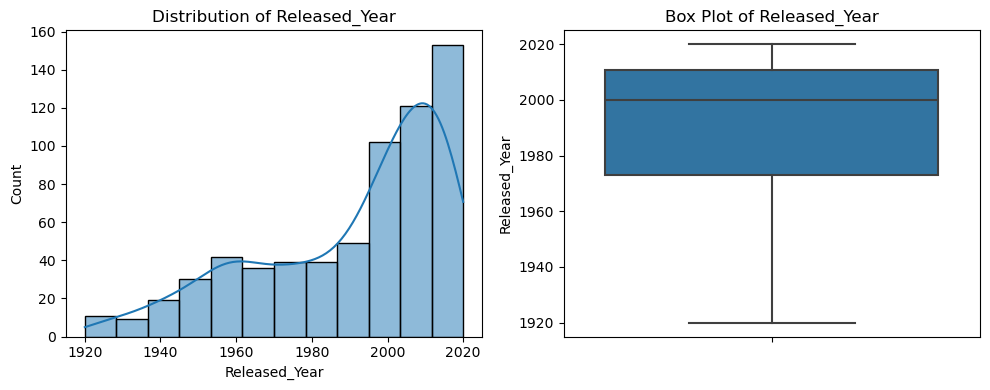

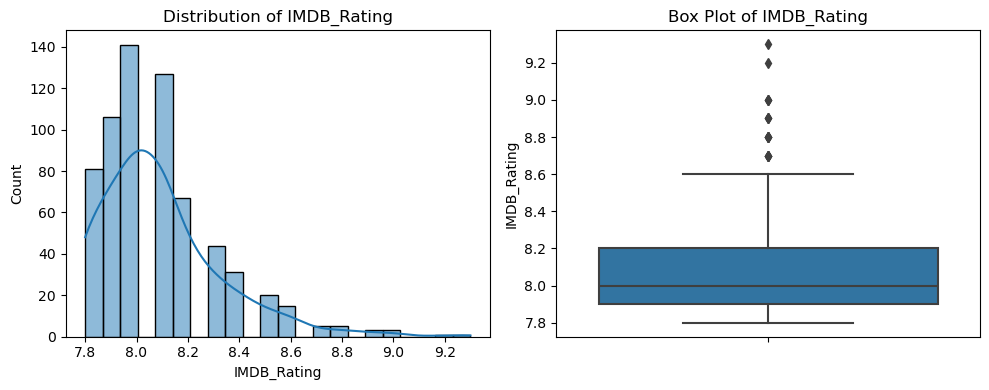

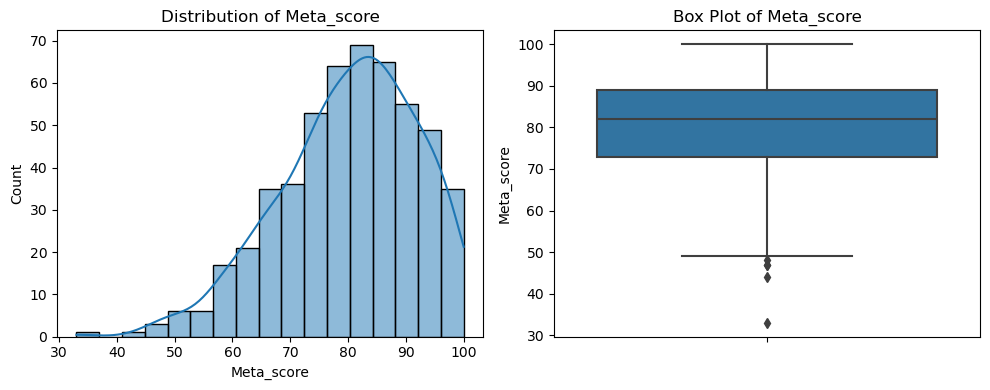

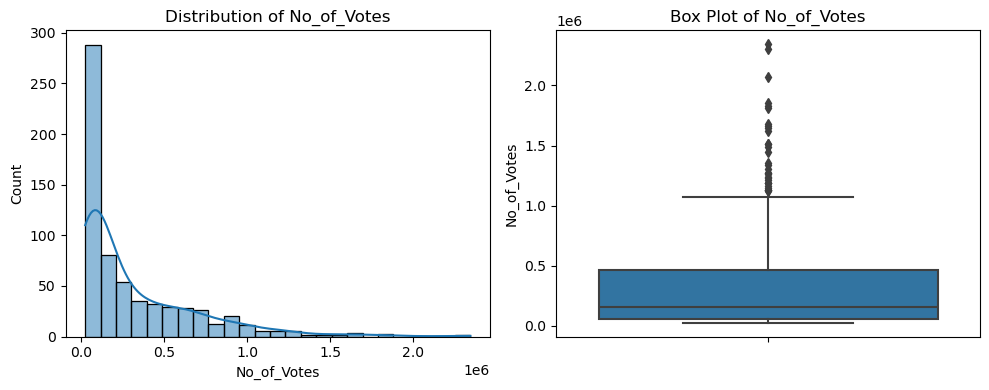

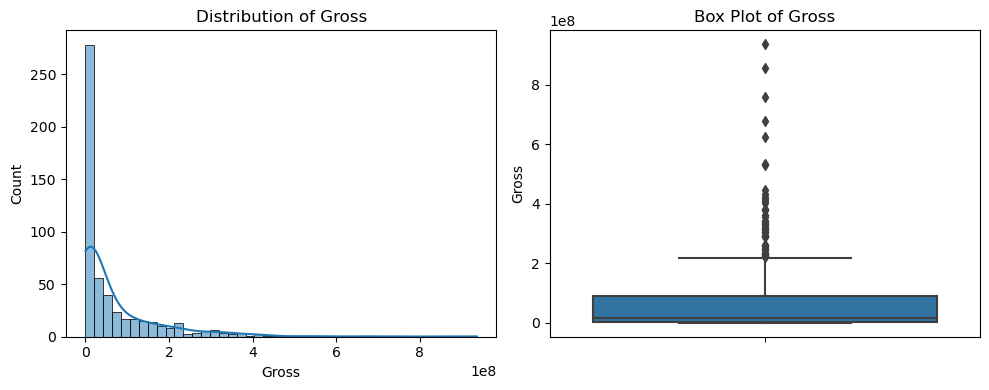


Categorical Columns Summary:

Genre value counts:
Genre
Drama                            57
Drama, Romance                   25
Crime, Drama                     21
Biography, Drama, History        20
Comedy, Drama                    20
                                 ..
Animation, Adventure, Fantasy     1
Comedy, Crime, Sport              1
Comedy, Crime, Romance            1
Adventure, Drama, Musical         1
Adventure, Drama, Romance         1
Name: count, Length: 173, dtype: int64
Genre unique values: 173


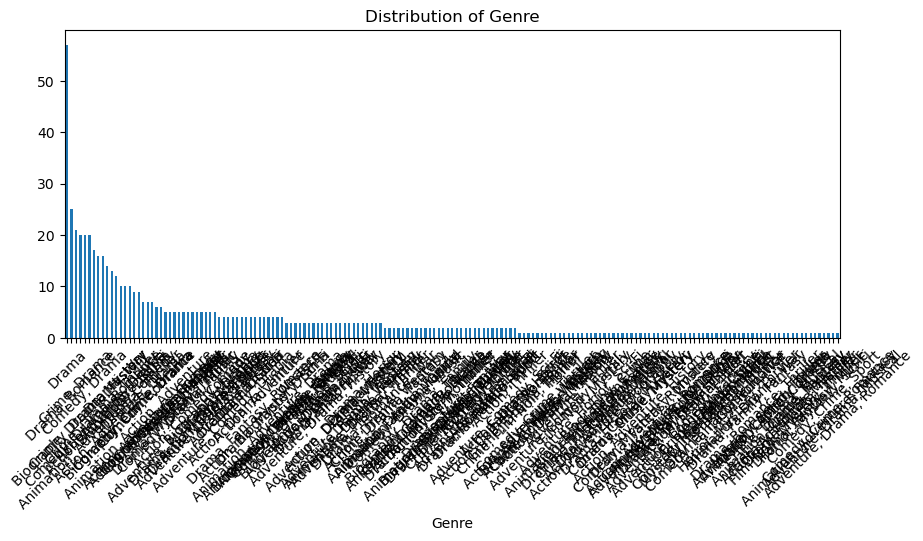


2.2 Bivariate Analysis
------------------------------


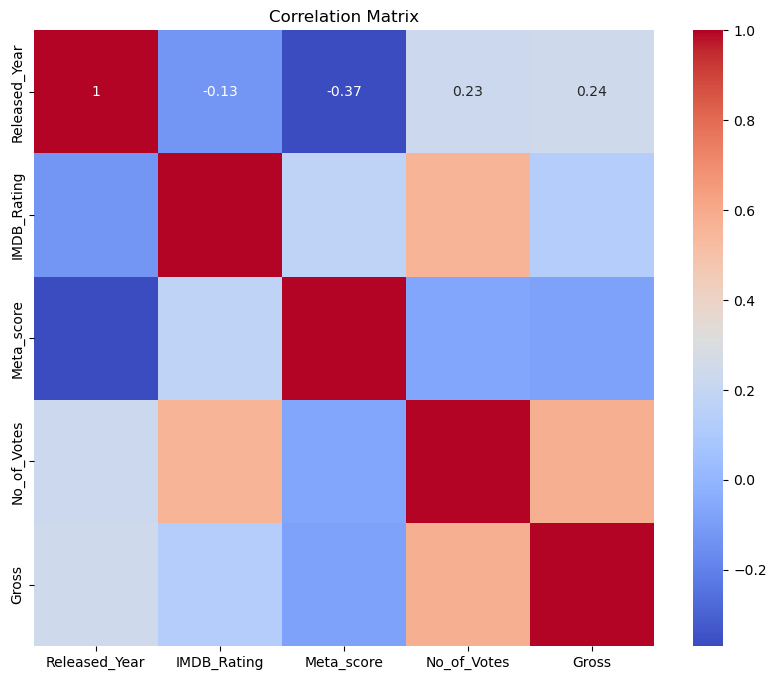

In [27]:
numerical_cols, categorical_cols = perform_eda(df)

In [28]:
X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(df, numerical_cols, categorical_cols)


3. Data Preprocessing
--------------------------------------------------

3.1 Handling Missing Values

3.2 Encoding Categorical Variables

3.3 Data Split Information:
Training set shape: (520, 6)
Testing set shape: (130, 6)


In [29]:
def perform_linear_regression_analysis(X_train, X_test, y_train, y_test):
    print("1. Model Training and Basic Information")
    print("-" * 50)
    
    # Generate feature names if not provided
    feature_names = [f"Feature_{i+1}" for i in range(X_train.shape[1])]
    
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Print shapes
    print(f"Training set shape: X_train - {X_train.shape}, y_train - {y_train.shape}")
    print(f"Testing set shape: X_test - {X_test.shape}, y_test - {y_test.shape}")
    
    print("\n2. Model Coefficients and Intercept")
    print("-" * 50)
    
    # Print coefficients and intercept
    print("\nModel Coefficients:")
    for name, coef in zip(feature_names, model.coef_):
        print(f"{name}: {coef:.4f}")
    print(f"\nIntercept: {model.intercept_:.4f}")
    
    print("\n3. Model Evaluation Metrics")
    print("-" * 50)
    
    # Calculate evaluation metrics
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred)
    }
    
    print("\nTraining Set Metrics:")
    print(f"R² Score: {metrics['train_r2']:.4f}")
    print(f"Mean Squared Error: {metrics['train_mse']:.4f}")
    print(f"Root Mean Squared Error: {metrics['train_rmse']:.4f}")
    print(f"Mean Absolute Error: {metrics['train_mae']:.4f}")
    
    print("\nTest Set Metrics:")
    print(f"R² Score: {metrics['test_r2']:.4f}")
    print(f"Mean Squared Error: {metrics['test_mse']:.4f}")
    print(f"Root Mean Squared Error: {metrics['test_rmse']:.4f}")
    print(f"Mean Absolute Error: {metrics['test_mae']:.4f}")
    
    print("\n4. Visualizations")
    print("-" * 50)
    
    # Actual vs Predicted Values Plot
    plt.figure(figsize=(12, 5))
    
    # Training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted (Training Set)')
    
    # Test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted (Test Set)')
    plt.tight_layout()
    plt.show()
    
    # Residuals Plot
    plt.figure(figsize=(12, 5))
    
    # Training set residuals
    plt.subplot(1, 2, 1)
    residuals_train = y_train - y_train_pred
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot (Training Set)')
    
    # Test set residuals
    plt.subplot(1, 2, 2)
    residuals_test = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot (Test Set)')
    plt.tight_layout()
    plt.show()
    
    # Residuals Distribution Plot
    plt.figure(figsize=(12, 5))
    
    # Training set residuals distribution
    plt.subplot(1, 2, 1)
    sns.histplot(residuals_train, kde=True)
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution (Training Set)')
    
    # Test set residuals distribution
    plt.subplot(1, 2, 2)
    sns.histplot(residuals_test, kde=True)
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution (Test Set)')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance Plot
    plt.figure(figsize=(10, 6))
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': np.abs(model.coef_)
    })
    importance = importance.sort_values('Coefficient', ascending=True)
    
    plt.barh(importance['Feature'], importance['Coefficient'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'predictions': {
            'train': y_train_pred,
            'test': y_test_pred
        },
        'metrics': metrics
    }

In [30]:
def print_regression_summary(results):
    print("\n5. Summary and Observations")
    print("-" * 50)
    
    metrics = results['metrics']
    
    print("\nModel Performance Summary:")
    print(f"- The model explains {metrics['test_r2']*100:.2f}% of the variance in the test set")
    
    # Compare train and test performance
    r2_diff = abs(metrics['train_r2'] - metrics['test_r2'])
    if r2_diff > 0.1:
        print("- There might be some overfitting as the training and test R² scores differ significantly")
    else:
        print("- The model shows consistent performance between training and test sets")
    
    # Evaluate RMSE
    print(f"- The average prediction error (RMSE) on the test set is {metrics['test_rmse']:.4f}")
    
    # Model reliability
    if metrics['test_r2'] < 0.5:
        print("- The model's predictive power is relatively weak")
    elif metrics['test_r2'] < 0.7:
        print("- The model's predictive power is moderate")
    else:
        print("- The model shows strong predictive power")

1. Model Training and Basic Information
--------------------------------------------------
Training set shape: X_train - (520, 6), y_train - (520,)
Testing set shape: X_test - (130, 6), y_test - (130,)

2. Model Coefficients and Intercept
--------------------------------------------------

Model Coefficients:
Feature_1: 989283.7718
Feature_2: 256519.9531
Feature_3: -483408.2144
Feature_4: -35493754.8191
Feature_5: 6984975.5109
Feature_6: 77470536.7732

Intercept: 71493854.8668

3. Model Evaluation Metrics
--------------------------------------------------

Training Set Metrics:
R² Score: 0.4434
Mean Squared Error: 6853057445740266.0000
Root Mean Squared Error: 82783195.4308
Mean Absolute Error: 50270570.8587

Test Set Metrics:
R² Score: 0.5404
Mean Squared Error: 4889522910283150.0000
Root Mean Squared Error: 69925123.5986
Mean Absolute Error: 46097990.8603

4. Visualizations
--------------------------------------------------


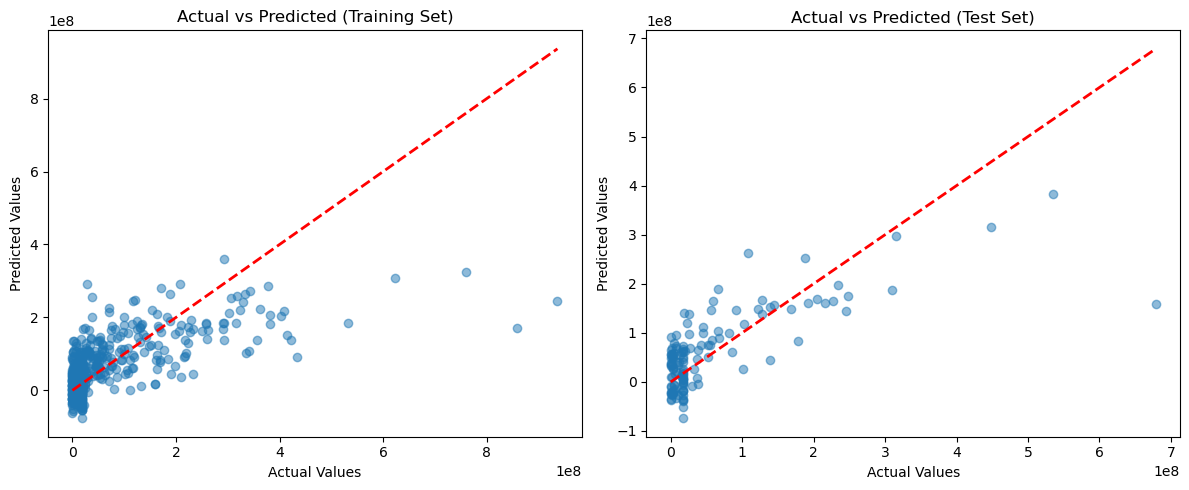

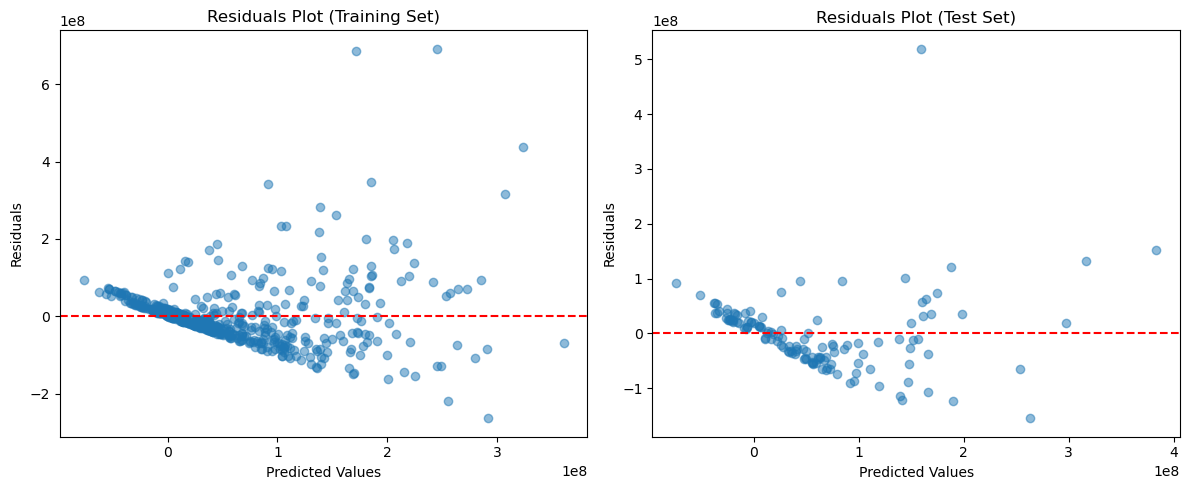

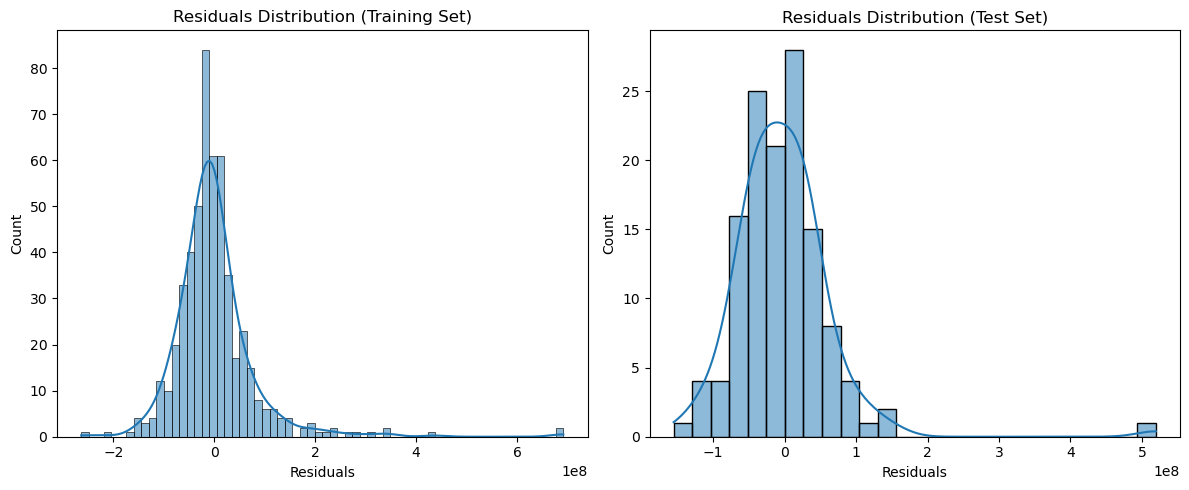

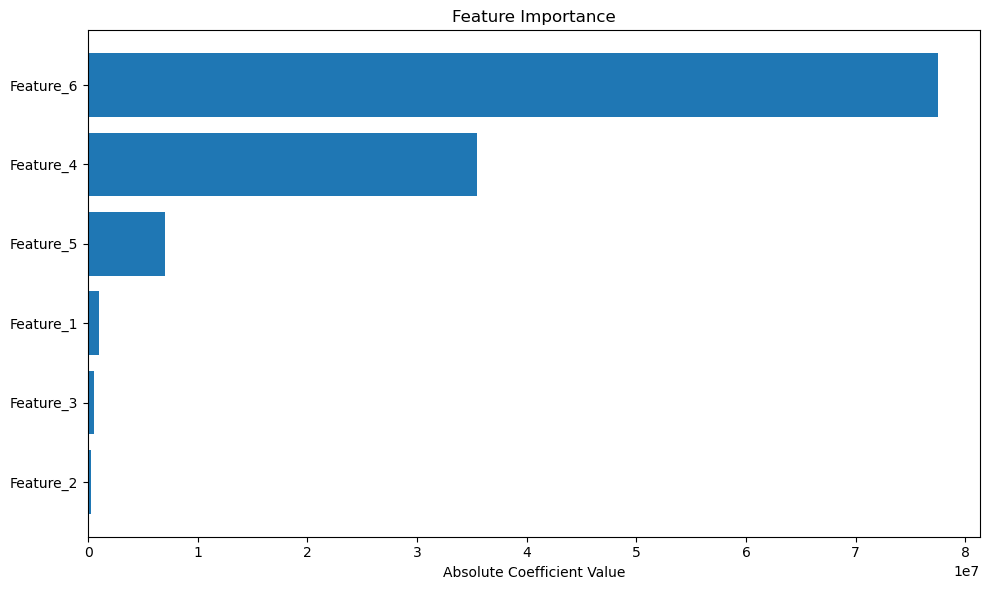


5. Summary and Observations
--------------------------------------------------

Model Performance Summary:
- The model explains 54.04% of the variance in the test set
- The model shows consistent performance between training and test sets
- The average prediction error (RMSE) on the test set is 69925123.5986
- The model's predictive power is moderate


In [31]:
results = perform_linear_regression_analysis(X_train, X_test, y_train, y_test)
print_regression_summary(results)

1. Model Performance:


The model has moderate predictive power, explaining about 54% of the variance in the test data (R² = 0.5404)
There's a reasonably consistent performance between training (R² = 0.4434) and test sets, indicating the model isn't overfitting
The slightly better performance on the test set suggests the model generalizes well to new data


2. Error Analysis:


The Root Mean Squared Error (RMSE) is approximately $69.9 million
The Mean Absolute Error (MAE) is about $46.1 million
These large error values suggest significant variability in movie gross predictions
The difference between MAE and RMSE indicates the presence of some large prediction errors (outliers)


3. Feature Importance (based on coefficients):


Feature_6 has the largest positive impact (coefficient: +77.5M)
Feature_4 has the largest negative impact (coefficient: -35.5M)
Features 1, 2, and 5 have relatively moderate positive impacts
Feature_3 has a moderate negative impact

1. Actual vs Predicted Values Plot: Shows how well the model's predictions match the actual values for both the training and testing sets.
2. Residuals Plot: Displays the residuals (differences between predicted and actual values) against the predicted values to check for any patterns.
3. Residuals Distribution Plot: Shows the distribution of residuals to check if they are normally distributed.
4. Feature Importance Plot: Visualizes the absolute values of the coefficients to understand the importance of each feature.